In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from typing import Callable, Any, List, Dict
from matplotlib import pyplot as plt

class Net(nn.Module):
    def __init__(
        self,
        structure: List[int],
        activations: Dict[str, Callable],
        initializer: Callable[..., Any] = lambda w: nn.init.uniform_(w, -1.0, 1.0),
    ):
        super(Net, self).__init__()
        # activate functions
        self.f = activations['hidden_layers']
        self.g = activations['output_layer']
        # an affine operation: y = Wx + b
        self.layer_num: int = len(structure)
        for l in range(1, self.layer_num):
            setattr(self, "fc%d" % l, nn.Linear(structure[l - 1], structure[l]))
            initializer(getattr(self, "fc%d" % l).weight)

    def forward(self, x: torch.Tensor):
        # Hidden layers
        for l in range(1, self.layer_num - 1):
#             print(x.size, getattr(self, "fc%d" % l).weight, getattr(self, "fc%d" % l).bias)
            x = self.f(getattr(self, "fc%d" % l)(x))
        # Output layer
        l = self.layer_num - 1
        x = self.g(getattr(self, "fc%d" % l)(x))
        return x

Training Data Size: torch.Size([4, 2])
Teaching Data Size: torch.Size([4, 1])
1 0.774551272392273
1000 0.5659090876579285
2000 0.5094255805015564
3000 0.48714137077331543
4000 0.128623828291893
5000 0.048148103058338165
6000 0.025046849623322487
7000 0.014588570222258568
8000 0.008966173976659775
9000 0.005680650006979704
10000 0.0036725904792547226


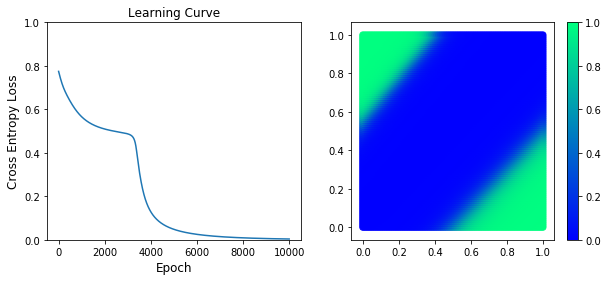

In [3]:
# -----------------------< Xor Problem >--------------------------
if __name__ == "__main__":
    # Setting Training and Teaching Data
    TRAINING_DATA: torch.Tensor = torch.tensor(
        [[0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 1.0]]
    )
    TEACHING_DATA: torch.Tensor = torch.tensor(
        [[0.0], [1.0], [1.0], [0.0]])
    print('Training Data Size:', TRAINING_DATA.size())
    print('Teaching Data Size:', TEACHING_DATA.size())
    # Setting Hyperparameters
    EPOCH: int = 10000
    structure: List[int] = [2, 2, 1]
    lr: float = 0.5
    weight_decay = 1e-5
    initial_value: float = (6 / (structure[0] + structure[-1])) ** 0.5
    error_boundary: float = 1e-3
    # Setting Neural Network
    initializer: Callable[..., Any] = lambda weights: nn.init.uniform_(
        weights, -initial_value, initial_value
    )
    """
    Choose
      activate function (activations),
      loss funcction (criterion),
      optimization algorithm (optimizer)
    from options shown below.
    
      < Activate function >
        Sigmoid: torch.sigmoid
        Tanh: torch.tanh
        ReLU: torch.relu
      ------------------------------------------------------------------
          activations = {'hidden_layers': func, 'output_layer': func}
          hidden_layers: Hidden layers activate function
          output_layer: Output layer activate function
      ------------------------------------------------------------------
    
      < Loss function >
        Mean Square Error: nn.MSE()
        Cross Entropy Loss: nn.CrossEntropyLoss()

      < Optimization algorithm >
        Stochastic Gradient Descent: optim.SGD(net.parameters())
        Adam: optim.Adam(net.parameters())
        
    """
    activations: Dict[str, Callable] = {
        'hidden_layers': torch.tanh,
        'output_layer': torch.sigmoid
    }
    net = Net(structure, activations, initializer)
#     criterion = nn.MSELoss()
    criterion = nn.BCELoss()
#     optimizer = optim.SGD(net.parameters(), lr = lr, weight_decay = weight_decay)
    optimizer = optim.Adam(net.parameters(), weight_decay = weight_decay)

    # Learning Data
    Loss = []
    for epoch in range(1, EPOCH + 1):
        optimizer.zero_grad()
        output = net(TRAINING_DATA)
        loss = criterion(output, TEACHING_DATA)
        loss.backward()
        optimizer.step()
        Loss.append(float(loss))
        if Loss[-1] < error_boundary:
            print(epoch, Loss[-1])
            print("----- End Learning -----")
            break
        if epoch % 1000 == 0 or epoch == 1:
            print(epoch, Loss[-1])
        
    # ------< Plot Learning Result >------
    x = np.arange(0.0, 1.01, 0.01)
    y = np.arange(0.0, 1.01, 0.01)
    Z = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            inputs = torch.tensor([[x[i]], [y[j]]]).T
            outputs = float(net(inputs))
#             print(outputs)
            Z[i][j] = np.squeeze(outputs)
    X, Y = np.meshgrid(x, y)

    plt.figure(figsize = (10, 4))
    plt.subplot(121)
    plt.plot(np.arange(len(Loss)), Loss)
    plt.title('Learning Curve')
    plt.xlabel('Epoch', fontsize = 12)
    plt.ylabel('Cross Entropy Loss', fontsize = 12)
    plt.ylim(0.0, 1.0)
    plt.subplot(122)
    plt.scatter(X, Y, c = Z, cmap = 'winter', vmin = 0, vmax = 1)
    plt.colorbar()

tensor([0.0000, 0.0000, 0.0343, 0.0815, 0.0000])
